
1. Resume Screener
2. Technical Evaluator
3. HR Interviewer
4. Offer Letter Generator

In [521]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [522]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages.ai import AIMessage

In [523]:
class State(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages]

In [524]:
@tool
def resume_screener(resume:str,skill:str):
    """This tool checks andd validates if the resume and the skills passed are in cync or not and returns its response """
    
    llm = ChatOpenAI()
    system = """You are an expert in screenring the resume and selecting OR rejecting the resume based on the skill we require.
                use your atmost intelligence and decide if you want to select the resume OR reject the resume by going through the resume clearly and comparing it will skills we want
                Here are some sample keywords you can check in resume.
                Data Engineer, Big Data, AWS, Azure, SQL Python -- maps to Data Engineer skill
                Data Sceince, ML , Deep Learning, DL, sklearn -- maps to Data Sceince skill
                """
    human_str =  """
                 Here is the resume 
                 ---------
                 {resume}

                 Please check if it maps to the follwoing skills : {skill}
                 """
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_str),
        ]
    )

    question_router = route_prompt | llm #structured_llm_router
    response = question_router.invoke({"resume":resume,"skill":skill})
    return {"messages": [response]}
    # state["messages"].append(AIMessage(content=response.content))

In [525]:
@tool
def hr_filter(resume:str):
    """This tool checks and validates Abilities, Competencies, Strengths, Capabilities, and Expertise in Resume """

    llm = ChatOpenAI()
    system = """You are an HR specialist tasked with reviewing resumes to evaluate the candidate's suitability for HR-related roles, Please dont be very tough guy, evaluate easy and if resume satisfies the basic HR skills also, you should pass it.
                Focus solely on assessing the candidate's abilities, competencies, strengths, capabilities, and expertise in core HR functions,
                such as talent management, recruitment, employee relations, performance evaluation, training and development, and compliance
                with HR policies. Avoid analyzing technical or non-HR skills and respond with a crisp message if you are satisfied with the candidate on the skills you have evaluated.
                """
    human_str =  """
                 Here is the resume 
                 ---------
                 {resume}
                 """
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_str),
        ]
    )

    question_router = route_prompt | llm
    response = question_router.invoke({"resume":resume})
    return {"messages": [response]}
    # state["messages"].append(AIMessage(content=response.content))

In [526]:
# # Initial state
# state = {"messages": []}

# # Run resume_screener_node and inspect state
# state = resume_screener_node(state)
# print("\nState after resume_screener_node:")
# from pprint import pprint
# pprint(state)

# # Run hr_node and inspect state
# state = hr_node(state)
# print("\nState after hr_node:")
# pprint(state)

# # Run resume_summarize_node and inspect state
# state = resume_summarize_node(state)
# print("\nState after resume_summarize_node:")
# pprint(state)


In [527]:
@tool
def resume_summarize():
    """Summarizes the thoughts from previous agents."""
    # if "messages" not in state or not state["messages"]:
    #     raise ValueError("State must include a 'messages' key with content.")

    llm = ChatOpenAI()
    system = """
        You are a resume summarizer. Summarize feedback from the previous agents.
        Provide one of these decisions: human_review_needed, rejected, selected.
    """

    # Gather all messages from previous agents
    agent_messages = "\n\n".join(
        msg.content for msg in state['messages']
    )

    human_str = """
    Summarize the feedback from the agents based on the messages below:
    ------
    {agent_messages}
    ------
    Provide one of these decisions: human_review_needed, rejected, selected.
    """

    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_str),
        ]
    )

    question_router = route_prompt | llm
    response = question_router.invoke({"agent_messages": agent_messages})

    # Append the AI message to state
    state["messages"].append(AIMessage(content=response.content))

    return state


In [528]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [529]:
llm = ChatOpenAI()

In [549]:
resume_screener_agent = create_react_agent(
    llm,
    tools = [resume_screener],
    state_modifier=make_system_prompt(
        "You can filter resumes based on the skill and return if we can select OR reject the resume. select it if resume suits the skillset, reject if resume doesn't suit the skillset" 
    )
)

In [531]:
def resume_screener_node(state: State) -> State:
    result = resume_screener_agent.invoke(state)
    state["messages"].extend(result["messages"])  # Append summarizer messages
    return state


In [532]:
hr_filter_agent = create_react_agent(
    llm,
    [hr_filter],
    state_modifier=make_system_prompt(
        "you work with resume screener agent and after only if resume screener agent select , then you will validate the HR skills in the resume"
    ),
)

In [533]:
def hr_node(state: State) -> State:
    result = hr_filter_agent.invoke(state)
    state["messages"].extend(result["messages"])  # Append summarizer messages
    return state

In [534]:
resume_summarize_agent = create_react_agent(
    llm,
    [resume_summarize],
    state_modifier=make_system_prompt(
        "you work with resume screener agent, hr agent and just summarises what those 2 agents feel about the resume "
    ),
)

In [535]:
def resume_summarize_node(state: State) -> State:
    result = resume_summarize_agent.invoke(state)
    state["messages"].extend(result["messages"]) 
    return state

In [536]:
def router(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        return END
    return "continue"

In [537]:
workflow = StateGraph(State)


In [538]:
workflow.add_node("resume_screener_node", resume_screener_node)
workflow.add_node("hr_node", hr_node)
workflow.add_node("resume_summarize", resume_summarize)

In [539]:
# workflow.add_conditional_edges(
#     "resume_screener_node",
#     router,
#     {"continue": "hr_node", END: END},
# )
# workflow.add_conditional_edges(
#     "hr_node",
#     router,
#     {"continue": "resume_screener_node", END: END},
# )


In [540]:
workflow.add_edge(START, "resume_screener_node")

workflow.add_edge("resume_screener_node","hr_node")

workflow.add_edge("hr_node","resume_summarize")

workflow.add_edge("resume_summarize",END)

graph = workflow.compile()

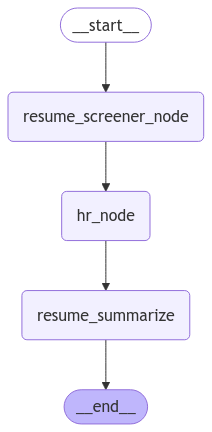

In [541]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [548]:
resume1 = """
**Praveen Reddy**  
📧 praveen@gmail.com | 📱 +91 98765 43210 | 🌐 LinkedIn: linkedin.com/in/praveen-reddy | 📍 Bangalore, India  

---

### **Professional Summary**  
A results-driven **Data Engineer** with 5+ years of experience in designing, developing, and managing data pipelines and workflows in **Azure** and **AWS** environments. Skilled in big data tools, data modeling, and cloud-based ETL processes. Proficient in aligning technical solutions with business goals while fostering collaborative work environments. Strong interpersonal and HR competencies ensure seamless collaboration across cross-functional teams.  

---

### **Technical Skills**  
**Cloud Platforms**: Azure (Data Factory, Synapse, Data Lake), AWS (Glue, Redshift, S3, EMR)  
**Big Data**: Apache Spark, Hadoop, PySpark  
**ETL Tools**: Azure Data Factory, AWS Glue  
**Databases**: SQL, NoSQL, PostgreSQL, MongoDB  
**Programming**: Python, Scala, SQL  
**Other Tools**: Docker, Kubernetes, Terraform  

---

### **HR-Specific Strengths**  
- **Collaboration and Teamwork**: Proven ability to work with diverse teams across engineering, business, and HR units, ensuring projects align with organizational goals.  
- **Effective Communication**: Adept at explaining technical concepts in simple terms to non-technical stakeholders and leadership.  
- **Adaptability**: Thrives in dynamic environments and quickly learns new technologies and workflows.  
- **Leadership and Mentorship**: Regularly guide junior engineers and interns in professional development and skill-building.  
- **Conflict Resolution**: Skilled in resolving team conflicts and fostering a positive, productive work environment.  

---

### **Professional Experience**  

**Senior Data Engineer**  
*XYZ Corporation, Bangalore, India*  
*Jan 2021 – Present*  
- Designed and implemented scalable **data pipelines** in **Azure Data Factory** and **AWS Glue** to process and analyze large datasets.  
- Spearheaded data integration projects, integrating sources like IoT, CRM, and operational databases into **AWS Redshift** and **Azure Synapse Analytics**.  
- Improved data processing times by 35% through optimization of **Apache Spark** jobs.  
- Collaborated with HR and IT to implement a talent analytics dashboard, providing insights into workforce performance.  
- Conducted workshops for cross-functional teams on data-driven decision-making and analytics tools.  

**Data Engineer**  
*ABC Solutions, Hyderabad, India*  
*July 2018 – Dec 2020*  
- Developed automated ETL workflows in **AWS Lambda** and **Azure Functions** for seamless data ingestion.  
- Maintained and monitored **Azure Data Lake** storage, ensuring high availability and security.  
- Worked closely with HR and marketing teams to create reporting solutions for employee engagement surveys and campaign ROI metrics.  
- Mentored three junior team members, improving team productivity by 20%.  

---

### **Education**  
**Bachelor of Technology in Computer Science Engineering**  
*Osmania University, Hyderabad, India*  
*2014 – 2018*  

---

### **Certifications**  
- **Microsoft Certified: Azure Data Engineer Associate**  
- **AWS Certified Data Analytics – Specialty**  

---

### **Achievements**  
- Streamlined HR analytics by automating survey data pipelines, reducing reporting time by 50%.  
- Awarded **"Employee of the Year"** (2022) for leading a cross-functional data migration project.  

---

### **Hobbies and Interests**  
- Mentoring aspiring engineers through LinkedIn learning groups.  
- Reading books on behavioral psychology and people management.  

--- 

This resume integrates both technical expertise and HR skills, making it balanced and impactful.

"""

config = {
    "configurable": {
        "thread_id": "123456"
    }
}


events = graph.stream(
    {
        "messages": [
            (
                "user",
                f"{resume1} . Please validate if the resume suits the Data Engineering skillset.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 5}

)
for s in events:
    print(s)
    print("----")
    # print(type(s))
    if "resume_summarize" in s.keys():
        print("We have -->>",s['resume_summarize']['messages'][-1].content ," resume !!!!!!")


{'resume_screener_node': {'messages': [HumanMessage(content='\n**Praveen Reddy**  \n📧 praveen@gmail.com | 📱 +91 98765 43210 | 🌐 LinkedIn: linkedin.com/in/praveen-reddy | 📍 Bangalore, India  \n\n---\n\n### **Professional Summary**  \nA results-driven **Data Engineer** with 5+ years of experience in designing, developing, and managing data pipelines and workflows in **Azure** and **AWS** environments. Skilled in big data tools, data modeling, and cloud-based ETL processes. Proficient in aligning technical solutions with business goals while fostering collaborative work environments. Strong interpersonal and HR competencies ensure seamless collaboration across cross-functional teams.  \n\n---\n\n### **Technical Skills**  \n**Cloud Platforms**: Azure (Data Factory, Synapse, Data Lake), AWS (Glue, Redshift, S3, EMR)  \n**Big Data**: Apache Spark, Hadoop, PySpark  \n**ETL Tools**: Azure Data Factory, AWS Glue  \n**Databases**: SQL, NoSQL, PostgreSQL, MongoDB  \n**Programming**: Python, Scala